# Mean squared displacement and proton transfer free energy landscape

Here we show how to calculate mean squared displacement (diffusion coefficients), both for "normal" atoms like Na, and for Grotthuss-diffusing hydroxide ions.

One "unique selling point" of lionanalysis is that it can follow multiple hydroxide ions. The positions are mapped from one frame to the next using the Hungarian algorithm.

**When calculating MSD always set the IntelligentUnwrap input option near the top of the file!**

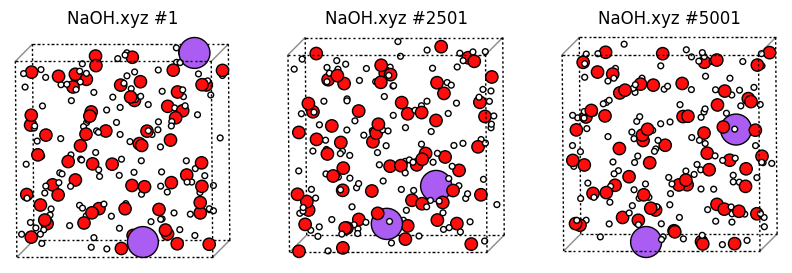

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from common import plot_trajectory
plot_trajectory("trajectories/NaOH.xyz");
# mole fraction NaOH = 0.031, for comparison with Hellstrom et al. papers

In [144]:

%%sh
cat > msdptfel1.config <<EOF
DumpFile trajectories/NaOH.xyz
DumpFileFormat mattixyz
Overwrite
CoutFrequency 200

### IMPORTANT ALWAYS SET IntelligentUnwrap for MSD !!!! #####

IntelligentUnwrap
BasicTimeUnit 0.005

DefineGroup H ATOMICNUMBER H
DefineGroup O ATOMICNUMBER O
DefineGroup Na ATOMICNUMBER Na

DefineGroup SuperO FINDSHORTEST FromGroup H ToGroup O
DefineGroup WaterO SUBGROUPCN SuperO Coord 2
DefineGroup HydroxideO SUBGROUPCN SuperO Coord 1

RDF Na O rdf_na_o.txt Resolution 0.05 MaxDist 6.0
RDF Na HydroxideO rdf_na_hydroxideo.txt Resolution 0.05 MaxDist 6.0

TMSD ParentGroup Na Group Na MaxHistory 2.0 RealTime Filename msd_na.txt PrintEvery 1000 OldMemberEscape1 0 0 0 UR @
TMSDFollow ParentGroup HydroxideO Group O Filename msd_hydroxide.txt Hungarian HungarianSquaredPenalty  IgnoreConflicts MaxHistory 2.0 RealTime PrintEvery 10 PrintIdsFilename hydroxide_ids.txt

EOF
OMP_NUM_THREADS=1 lionanalysis.exe msdptfel1.config > msdptfel1.out


## Sodium diffusion coefficient

   #t(ps)     value        sum  count
0   0.000  0.000000    0.00000  10002
1   0.005  0.000806    8.05569  10000
2   0.010  0.003202   32.01370   9998
3   0.015  0.007131   71.27790   9996
4   0.020  0.012499  124.91800   9994


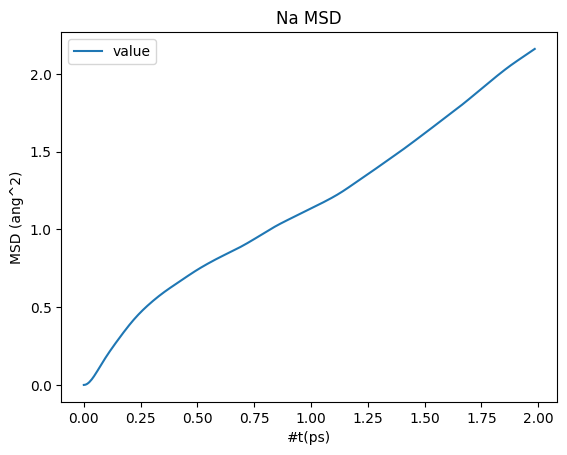

In [145]:
from common import msd2df
df = msd2df("msd_na.txt")
print(df.head())
df.plot(x="#t(ps)", y="value", ylabel="MSD (ang^2)", title="Na MSD");

This trajectory *clearly* isn't long enough to get a converged value for the diffusion coefficient.  But we would do something like the below.

Linear fit for diffusion coefficient should happen in linear regime, let's start from 0.50 ps:

In [146]:
from scipy.stats import linregress

def diffusion_coefficient_from_df(df: pd.DataFrame, min_t_ps: float = 0.5) -> float:
    """ Returns the diffusion coefficient doing a linear fit starting from min_t_ps. Returns D in m^2 s^-1"""
    filtered_df = df.loc[df["#t(ps)"] > min_t_ps]
    result = linregress(filtered_df["#t(ps)"], filtered_df["value"])
    D = result.slope / 6  # ang^2/ps
    D = D * 1e-20 / 1e-12    # m^2 / s
    return D

D = diffusion_coefficient_from_df(df, min_t_ps=0.5)
print(f"Na diffusion coefficient: {D:.2e} m^2 s^-1")

Na diffusion coefficient: 1.60e-09 m^2 s^-1


According to [Hellstrom, Ceriotti, Behler](https://doi.org/10.1021/acs.jpcb.8b06433), the converged value is about 1.3 10^-9 m^2 s^-1. So the agreement is very good!

## Hydroxide ion diffusion coefficient

   #t(ps)     value      sum  count
0   0.000  0.000000     0.00   9204
1   0.005  0.134619  1239.03   9204
2   0.010  0.235484  2167.40   9204
3   0.015  0.310378  2856.72   9204
4   0.020  0.343379  3160.46   9204


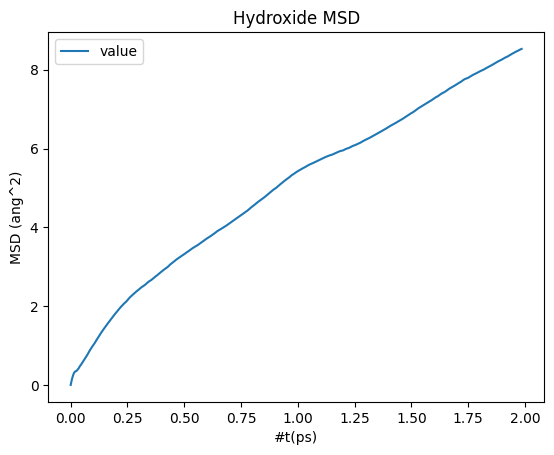

In [147]:
df = msd2df("msd_hydroxide.txt")
print(df.head())
df.plot(x="#t(ps)", y="value", ylabel="MSD (ang^2)", title="Hydroxide MSD");

In [148]:
D = diffusion_coefficient_from_df(df, min_t_ps=0.5)
print(f"Hydroxide diffusion coefficient: {D:.2e} m^2 s^-1")

Hydroxide diffusion coefficient: 5.73e-09 m^2 s^-1


According to Hellstrom, Ceriotti, Behler, the converged value is about 6.5e-9 m^2 s^-1, so the agreement is very good!


When using TMSDFollow, we can also use ``PrintIdsFilename`` to print the group members in the right order, such that the ids in a single column will correspond to the "same" hydroxide ion that diffuses through the system: 

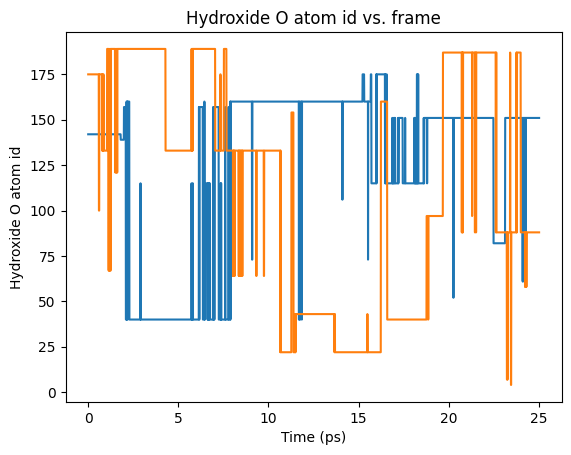

In [149]:
A = np.loadtxt("hydroxide_ids.txt")
basic_time_unit = 0.005
time = basic_time_unit * (np.arange(len(A))+1)
plt.plot(time, A)
plt.xlabel("Time (ps)")
plt.ylabel("Hydroxide O atom id")
plt.title("Hydroxide O atom id vs. frame");

Here, each "jump" represents a proton transfer event where the hydroxide is assigned to a new oxygen.

## Na-O radial distribution function
Let's also plot the Na-O radial distribution function. The first minimum is at about 3.2 angstrom. This will help us in the next step.

We also see that there are very few Na-Hydroxide direct-contact ion pairs.

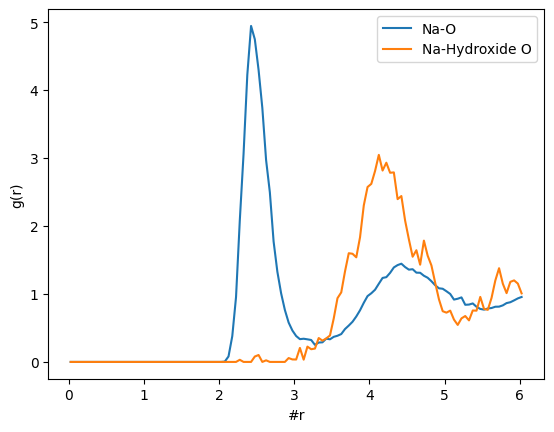

In [150]:
from common import rdf2df
_, ax = plt.subplots()
rdf2df("rdf_na_o.txt").plot(x=0, y=1, ax=ax)
rdf2df("rdf_na_hydroxideo.txt").plot(x=0, y=1, ax=ax)
ax.legend(["Na-O", "Na-Hydroxide O"]);
ax.set_ylabel("g(r)");



## Proton transfer free energy landscape

### Simple overall PTFEL

Proton transfer free energy landscapes (PTFEL) can be obtained using the ``DoubleCoordinationShortDelta`` command.

These kinds of landscapes were heavily analyzed in [Hellstrom, Behler](https://doi.org/10.1021/acs.jpclett.6b01448) and [Hellstrom, Quaranta, Behler](https://doi.org/10.1039/C8SC03033B) as a function of local environment around the proton donor and acceptor.

The proton transfer coordinate is the difference between the covalent O-H bond length in the donor and the H...O hydrogen bond towards the acceptor (in angstrom).

Let's calculate:

* The overall proton transfer free energy landscape (ptfel.txt)


In [151]:
%%sh
cat > msdptfel2.config <<EOF
DumpFile trajectories/NaOH.xyz
DumpFileFormat mattixyz
Overwrite
CoutFrequency 200

BasicTimeUnit 0.005

DefineGroup H ATOMICNUMBER H
DefineGroup O ATOMICNUMBER O
DefineGroup Na ATOMICNUMBER Na

DefineGroup SuperO FINDSHORTEST FromGroup H ToGroup O
DefineGroup WaterO SUBGROUPCN SuperO Coord 2
DefineGroup WaterH INVERTCOORDINATION WaterO
DefineGroup HydroxideO SUBGROUPCN SuperO Coord 1
DefineGroup SuperH INVERTCOORDINATION SuperO

HydrogenBond O SuperO H \
    NewGroup1 O...H NewGroup1CoordinationGroup 3

# after INTERSECTION, O...H must come first to preserve the coordination tables
DefineGroup HydroxideO...H INTERSECTION O...H HydroxideO
DefineGroup WaterO...H INTERSECTION O...H WaterO

# Simple overall proton transfer free energy landscape
DoubleCoordinationShortDelta  \
    Filename ptfel.txt \
    LHS HydroxideO...H SuperH LGroup3MustBe WaterO \
    RHS HydroxideO...H SuperH RGroup3MustBe WaterO \
    Resolution 0.1 PrintEvery 1000

EOF
OMP_NUM_THREADS=1 lionanalysis.exe msdptfel2.config > msdptfel2.out

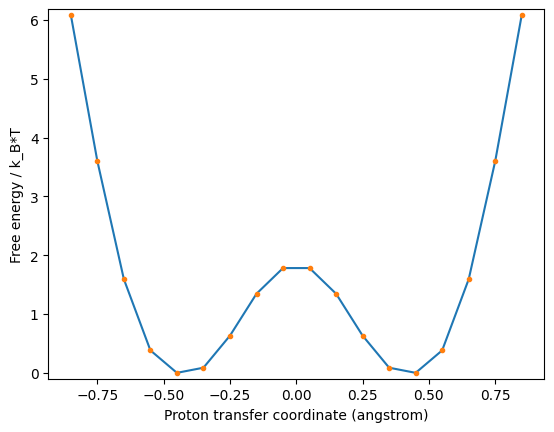

In [152]:
import numpy as np
import matplotlib.pyplot as plt

def plot_ptfel(x: np.array, y: np.array) -> plt.Axes:
    fig, ax = plt.subplots()
    # translate so bottom of the well is at zero
    # makes it easier to read the barrier
    y = np.array(y) - np.min(y)
    ax.plot(x, y, '-')
    ax.plot(x, y, '.')
    ax.set_xlabel("Proton transfer coordinate (angstrom)")
    ax.set_ylabel("Free energy / k_B*T");
    ax.set_ylim((-0.1, np.max(y[y != np.inf])+0.1));


A = np.loadtxt("ptfel.txt")
plot_ptfel(A[:, 0], A[:, 1])

Here, we see that the most common proton transfer coordinate is about 0.4 angstrom (lowest free energy), and the barrier is about 1.8 k_B * T.

This simulation was carried out at T = 300 K, so the barrier is in fact ``1.8 * 8.6e-5 eV/K * 300 K`` = 0.046 eV.

According to [Hellstrom, Behler](https://doi.org/10.1021/acs.jpclett.6b01448) the converged value is about 1.6 k_B * T at this NaOH concentration.

## Advanced PTFEL for local environments

Let's calculate:

* PTFEL for OH-(A=4) + H2O(A=2) -> H2O(A=3) + OH-(A=3), where ``A`` is the number of accepted hydrogen bonds. In Hellstrom/Behler this curve (for a different NaOH concentration) is shown as (3,2)->(2,3).

* PTFEL for OH-(X=1) + H2O -> H2O(X=1) + OH-, where ``X`` is the number of coordinated Na atoms by the O.

In [153]:

%%sh
cat > msdptfel3.config <<EOF
DumpFile trajectories/NaOH.xyz
DumpFileFormat mattixyz
Overwrite
CoutFrequency 200

BasicTimeUnit 0.005

DefineGroup H ATOMICNUMBER H
DefineGroup O ATOMICNUMBER O
DefineGroup Na ATOMICNUMBER Na

DefineGroup SuperO FINDSHORTEST FromGroup H ToGroup O
DefineGroup WaterO SUBGROUPCN SuperO Coord 2
DefineGroup WaterH INVERTCOORDINATION WaterO
DefineGroup HydroxideO SUBGROUPCN SuperO Coord 1
DefineGroup SuperH INVERTCOORDINATION SuperO

HydrogenBond O SuperO H \
    NewGroup1 O...H NewGroup1CoordinationGroup 3

# after INTERSECTION, O...H must come first to preserve the coordination tables
DefineGroup HydroxideO...H INTERSECTION O...H HydroxideO
DefineGroup WaterO...H INTERSECTION O...H WaterO

# PTFEL with particular hydrogen bonding requirements for both the acceptor and donor
DefineGroup HydroxideO(A=4)...H SUBGROUPCN HydroxideO...H Coord 4
DefineGroup HydroxideO(A=3)...H SUBGROUPCN HydroxideO...H Coord 3
DefineGroup WaterO(A=3)...H SUBGROUPCN WaterO...H Coord 3
DefineGroup WaterO(A=2)...H SUBGROUPCN WaterO...H Coord 2

DoubleCoordinationShortDelta  \
    Filename ptfel_hb_env.txt \
    LHS HydroxideO(A=4)...H SuperH LGroup3MustBe WaterO(A=2)...H \
    RHS HydroxideO(A=3)...H SuperH RGroup3MustBe WaterO(A=3)...H \
    Resolution 0.1 PrintEvery 1000

# PTFEL only requiring that either the acceptor or donor is coordinated to exactly 1 Na
DefineGroup O_Na BOND O Na MaxDist 3.2 MinCoord 0
DefineGroup O(X=1) SUBGROUPCN O_Na Coord 1
DefineGroup WaterO(X=1)...H INTERSECTION WaterO...H O(X=1)
DefineGroup HydroxideO(X=1)...H INTERSECTION HydroxideO...H O(X=1)

DoubleCoordinationShortDelta  \
    Filename ptfel_coordinated_to_Na.txt \
    LHS HydroxideO(X=1)...H SuperH LGroup3MustBe WaterO \
    RHS HydroxideO...H SuperH RGroup3MustBe WaterO(X=1)...H \
    Resolution 0.1 PrintEvery 1000

AverageSize
EOF
OMP_NUM_THREADS=1 lionanalysis.exe msdptfel3.config > msdptfel3.out




### PTFEL for particular hydrogen bonding environment

The reaction is ``OH-(A=4) + H2O(A=2) -> H2O(A=3) + OH-(A=3)``. This emulates a "frozen" hydrogen bond environment where only the proton is transferred.

We see that the left-hand-side (LHS) is lower in free energy and therefore more commonly occuring than the RHS.

The RHS is quite high in energy - in fact there is an alternative hydrogen-bonding environment which gives a lower barrier and free energy of the product. See Hellstrom/Behler JPCL 2016 for details. This is an indication that proton transfer events are coupled to fluctuations in the hydrogen bonding environment.


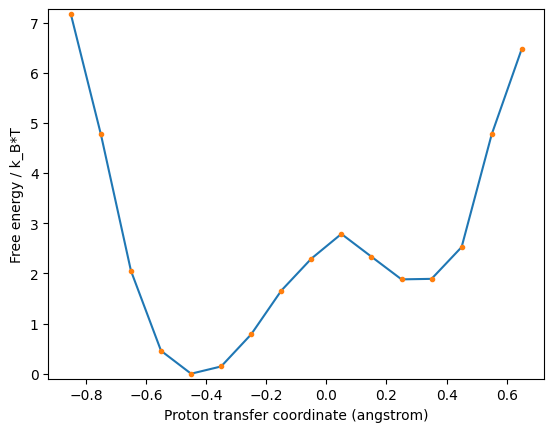

In [154]:
A = np.loadtxt("ptfel_hb_env.txt")
plot_ptfel(A[:, 0], A[:, 1])

### PTFEL for hydroxide/water coordinated to Na

The LHS is OH- coordinated to Na. From the RDF in the previous section we know that there are only very few such species, so we have extremely poor statistics and shouldn't put too much trust in the exact results. We would need *much* longer simulation to say anything at all.

The RHS is H2O coordinated to Na. It seems like for such molecules, the barrier is ~ 5 k_B T, which is much much larger than the 1.6 k_B T for the overall PTFEL. 

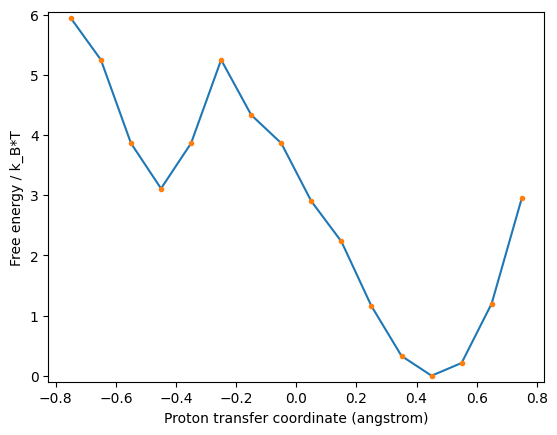

In [155]:
A = np.loadtxt("ptfel_coordinated_to_Na.txt")
plot_ptfel(A[:, 0], A[:, 1])